In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 26 18:11:27 2020

@author: gaudin antoine gaudinantoine95@gmail.com
"""

##install package
from datetime import timedelta
import numpy as np
import pandas as pd #to install beforehand
import matplotlib.pyplot as plt
import pulp as pulp #to install beforehand

##year, month and day, in this version, only the selection by year is used
#day=str(20170927)
Yearstart=2016
Yearend=2017
Month=1
Day=22

###origin of the data on the electricity price, WESM
df_large_wesm=pd.read_csv('2017pricewesm.csv') #actuallty got 2016 here too
df_large_wesm['Computed Date/Hr']=pd.to_datetime(df_large_wesm['Computed Date/Hr'])
df_large_wesm['GWAP Price']=df_large_wesm['GWAP Price'].replace('0,00', 0)
df_large_wesm['GWAP Price']=df_large_wesm['GWAP Price'].astype(float)
df_large_wesm=df_large_wesm.loc[df_large_wesm['Computed Date/Hr'].dt.year.isin([Yearstart,Yearend])]

#df_wholesale=df_PV_energy_price['RRP'].values #PhP per kWh
#df_wholesale=df_philip_energy_price3month['WESM_ex_ante'].values #PhP per MWh
df_wholesale=df_large_wesm['GWAP Price'].values
Time_Interval=1. #in hour
print('Finished reading price data')

Finished reading price data


In [3]:
###definition hydro entering system, can be adjusted
constant_debit=311 #m3 per second, average on a year
#df_hydro_entering_reservoir=[constant_debit*3600 for i in range(0,len(df_wholesale))]
df_month_rain=pd.read_csv('pagasanormvaltugcitycag1981-2010.csv')
rain_month=df_month_rain['rainfall_amount'][0:12]
debit_month=[rain_month[i]*constant_debit/np.average(rain_month) for i in range(0,len(rain_month))]#m3 per second
df_hydro_entering_reservoir=[debit_month[int(((24*i)/len(df_wholesale))%12)]*3600 for i in range(0,len(df_wholesale))]#m3 per hour

###definition limits of reservoir, inspired by Magat reservoir
reservoir_capacity_min=370000000 #m3
reservoir_capacity_max=670000000 #m3
reservoir_capacity_start=590000000 #m3, volume at the start and end of the problem
Height_dam=80 #m

minimum_debit=80#m3 per second, the minimum debit that shall be provided out of the barrage

###definition pump hydro
Power_max=360000 #in kW, positive
Power_min=0 #in kW, could be negative,to simulate reserve pumped-hydro

###conversion from m3 water to kWh
Efficiency_factor=0.9 #it has to be fixed, to ensure a linear problem
Conversion_m3_to_Joule=Height_dam*9.81*1000 #gravity, convert m3 to kg
Conversion_m3_to_kWh=float(Conversion_m3_to_Joule)/3600000 #convert m3 to kg
print('Finished setting-up parameters')

Finished setting-up parameters


In [4]:
###Start the optimization problem, we optimize revenue
model=pulp.LpProblem("Revenue maximization problem", pulp.LpMaximize)

###List all the variables to optimize, there are different classes, minimum and maximum values are stated here

#Charge-status, is equal to 1 if our pump works in reverse
Chg = pulp.LpVariable.dicts("Charge_status",
                                     ((time) for time in [i for i in range(0,len(df_wholesale))]),
                                     cat='Binary')

#disCharge-status, is equal to 1 if the pump discharge water
Dis = pulp.LpVariable.dicts("Discharge_status",
                                     ((time) for time in [i for i in range(0,len(df_wholesale))]),
                                     cat='Binary')
#reverse Power, electricity used from the grid, kW
P_Charge_kW = pulp.LpVariable.dicts("Power_charge",
                                     ((time) for time in [i for i in range(0,len(df_wholesale))]),
                                     lowBound=0,
                                     cat='Continuous')
#Power sent to the grid, kW
P_Discharge_kW = pulp.LpVariable.dicts("Power_discharge",
                                     ((time) for time in [i for i in range(0,len(df_wholesale))]),
                                     lowBound=0,
                                     cat='Continuous')
#Water in reservoir, m3
Hydro_m3 = pulp.LpVariable.dicts("Volume_reserve_water",
                                     ((time) for time in [i for i in range(0,len(df_wholesale))]),
                                     lowBound=reservoir_capacity_min,
                                     upBound=reservoir_capacity_max,
                                     cat='Continuous')

#Flow of Water not used for the electricity production but still dispersed #m3 per hour
Hydro_flow_lost= pulp.LpVariable.dicts("flow_water_lost",
                                     ((time) for time in [i for i in range(0,len(df_wholesale))]),
                                     lowBound=0,
                                     cat='Continuous')

###Objective function (the one to optimize), PhP
model += (
    pulp.lpSum([
        #Part 1 of my calculation, result expresed in PhP, df_wholesale is in PhP per MWh,and the power in kWh, Time interval in hour,
        #so we divide by 1000
        -df_wholesale[(i)]*P_Charge_kW[(i)]*Time_Interval/1000
        +df_wholesale[(i)]*P_Discharge_kW[(i)]*Time_Interval/1000
        for i in [i for i in range(0,len(df_wholesale))]])
)

### Constraints

for i in range(0,len(df_wholesale)):
    #maximum discharge and charge speed
    model += P_Discharge_kW[i]<=Power_max*Dis[i]
    model += P_Charge_kW[i] <=abs(Power_min)*Chg[i]
    
    #no charge and discharge at the same time
    model += Chg[i]+Dis[i] <= 1
    
    #minimum flow of water exiting the reservoir, minimum_debit in m3 per second, converted to m3 per hour
    model += 3600*minimum_debit <= Hydro_flow_lost[i]*Time_Interval-(P_Charge_kW[i]*Time_Interval*Efficiency_factor/Conversion_m3_to_kWh)+(1./Efficiency_factor)*P_Discharge_kW[i]*Time_Interval/Conversion_m3_to_kWh

#Formula to ensure contuinity of the water level
for i in range(1,len(df_wholesale)):
    model += Hydro_m3[i]==Hydro_m3[i-1]-Hydro_flow_lost[i-1]*Time_Interval+df_hydro_entering_reservoir[i-1]*Time_Interval+(P_Charge_kW[i]*Time_Interval*Efficiency_factor/Conversion_m3_to_kWh)-(1./Efficiency_factor)*P_Discharge_kW[i]*Time_Interval/Conversion_m3_to_kWh 

#imposed initial and final water level (if not, the reservoir would just empty by itself)
model += Hydro_m3[0]==reservoir_capacity_start
model += Hydro_m3[len(df_wholesale)-1]==reservoir_capacity_start

### solve it
model.solve()

#is the solution optimal? 
print(pulp.LpStatus[model.status]) 

Optimal


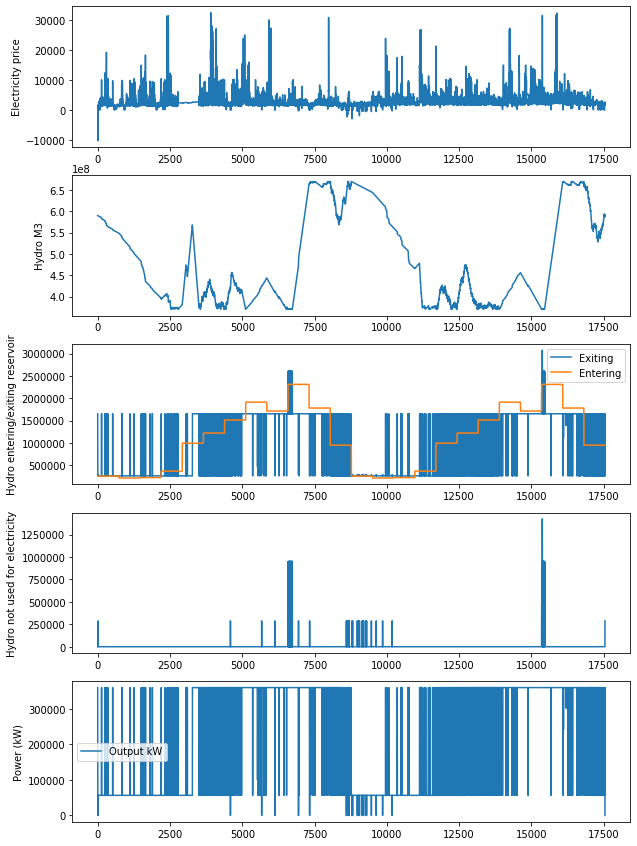

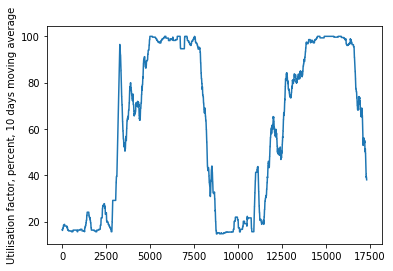

In [5]:
####present results in graphs
plt.close()

plt.figure(figsize=(10,15))
plt.title('Date (day, month, year) = %s, %s, %s'%(Day,Month,Yearstart))
plt.subplot(5, 1, 1)
plt.plot(df_wholesale)
plt.ylabel('Electricity price')
plt.subplot(5, 1, 2)
plt.plot([i for i in range(0,len(df_wholesale))],[Hydro_m3[i].varValue for i in range(0,len(df_wholesale))],label='Hydro m3')
plt.ylabel('Hydro M3')
plt.subplot(5, 1, 3)
plt.plot([i for i in range(0,len(df_wholesale))],[(P_Discharge_kW[i].varValue/Conversion_m3_to_kWh)+Hydro_flow_lost[i].varValue for i in range(0,len(df_wholesale))],label='Exiting')
plt.plot(df_hydro_entering_reservoir,label='Entering')
plt.ylabel('Hydro entering/exiting reservoir')
plt.legend()
plt.subplot(5, 1, 4)
plt.plot([i for i in range(0,len(df_wholesale))],[Hydro_flow_lost[i].varValue for i in range(0,len(df_wholesale))],label='Hydro m3 per hour')
plt.ylabel('Hydro not used for electricity')
plt.subplot(5, 1, 5)
plt.plot([i for i in range(0,len(df_wholesale))],[P_Discharge_kW[i].varValue for i in range(0,len(df_wholesale))],label='Output kW')
plt.ylabel('Power (kW)')
plt.legend()


plt.show()
plt.close()

#10 days moving average is 240 hours
plt.plot(np.convolve([P_Discharge_kW[i].varValue*100/Power_max for i in range(0,len(df_wholesale))], np.ones((240,))/240, mode='valid'))
plt.ylabel('Utilisation factor, percent, 10 days moving average')

plt.show()

In [6]:
### order and export to one Excel
df_final=pd.DataFrame(data={'Time': df_large_wesm['Computed Date/Hr'],
                            'Electricity price PhP per MWh': df_wholesale,
                            'Electricity production, kW': [P_Discharge_kW[i].varValue for i in range(0,len(df_wholesale))],
                            'Volume in reservoir, m3':[Hydro_m3[i].varValue for i in range(0,len(df_wholesale))],
                            'Volume entering reservoir, rain, m3 per hour' : df_hydro_entering_reservoir,
                            'Volume exiting reservoir, not used for electricity, m3 per hour' : [Hydro_flow_lost[i].varValue for i in range(0,len(df_wholesale))]})
df_final.to_excel("output.xlsx")

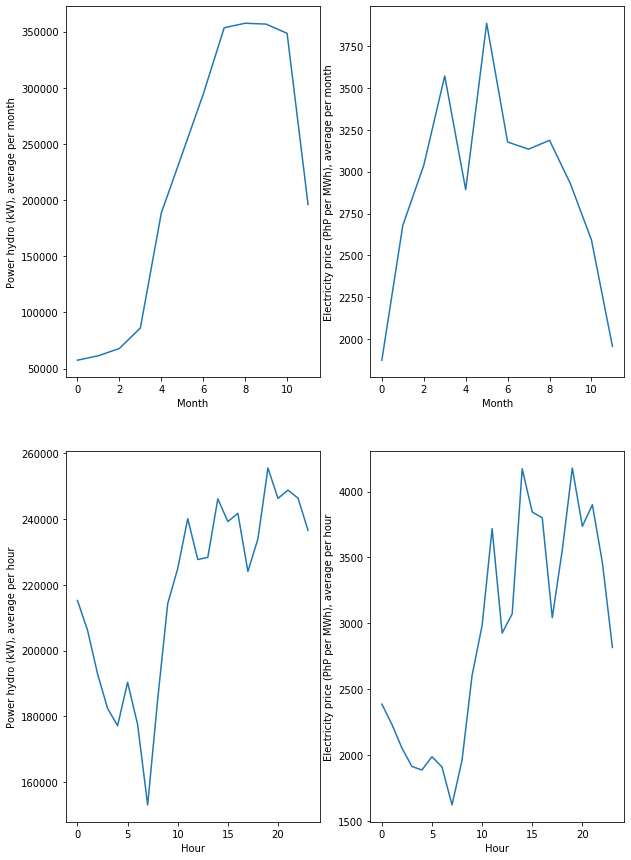

In [10]:
import numpy as np
import warnings

x = np.ones((1000, 1000)) * np.nan

# I expect to see RuntimeWarnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    foo = np.nanmean(x, axis=1)
    

### Average, per hour and month
# Average, per hour
Average_hour_prod=[0 for i in range(0,24)]
Average_hour_WESM=[0 for i in range(0,24)]
for i in range(0,24):
    Average_hour_prod[i]=np.average(df_final['Electricity production, kW'].loc[df_final['Time'].dt.hour==i])
    Average_hour_WESM[i]=np.average(df_final['Electricity price PhP per MWh'].loc[df_final['Time'].dt.hour==i])
# Average, per month
Average_month_prod=[0 for i in range(1,13)]
Average_month_WESM=[0 for i in range(1,13)]
for i in range(1,13):
    Average_month_prod[i-1]=np.average(df_final['Electricity production, kW'].loc[df_final['Time'].dt.month==i])
    Average_month_WESM[i-1]=np.average(df_final['Electricity price PhP per MWh'].loc[df_final['Time'].dt.month==i])

fig=plt.figure(figsize=(10,15))

plt.subplot(2, 2, 1)
plt.plot(Average_month_prod)
plt.xlabel('Month')
plt.ylabel('Power hydro (kW), average per month')

plt.subplot(2, 2, 2)
plt.plot(Average_month_WESM)
plt.xlabel('Month')
plt.ylabel('Electricity price (PhP per MWh), average per month')

plt.subplot(2, 2, 3)

plt.plot(Average_hour_prod)
plt.xlabel('Hour')
plt.ylabel('Power hydro (kW), average per hour')

plt.subplot(2, 2, 4)
plt.plot(Average_hour_WESM)
plt.xlabel('Hour')
plt.ylabel('Electricity price (PhP per MWh), average per hour')
plt.show()